Importing libaries 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
pd.set_option("display.max_rows", 30, "display.max_columns", None)

# IMPORT AND CLEANING

We import that dataframe and remove 2020-10 to 2021-04 since we are missing some values, and this data is during Covid so to avoid that skew we removed the data

In [3]:
df = pd.read_csv(Path('Resources\DataforMLtesting.csv'))
df = df[~df['REF_DATE'].isin(['2020-10', '2021-01', '2021-04'])]
df.tail()

,Unnamed: 0,REF_DATE,GEO,DGUID,National Occupational Classification,Job vacancy characteristics,Statistics,VALUE,STATUS
2961,23746440,2020-01,Nunavut,2016A000262,"Business, finance and administration occupatio...",Full-time,Job vacancies,55.0,D
2962,23755273,2020-01,Nunavut,2016A000262,Natural and applied sciences and related occup...,Full-time,Job vacancies,45.0,D
2963,23755276,2020-01,Nunavut,2016A000262,Natural and applied sciences and related occup...,Part-time,Job vacancies,0.0,A
2964,23792783,2020-01,Nunavut,2016A000262,"Trades, transport and equipment operators and ...",Full-time,Job vacancies,85.0,D
2965,23792786,2020-01,Nunavut,2016A000262,"Trades, transport and equipment operators and ...",Part-time,Job vacancies,0.0,A


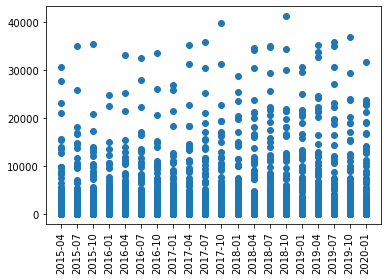

In [4]:
plt.scatter(df.REF_DATE, df.VALUE)
plt.xticks(rotation = 90)
plt.show()

Dropping uneeded columns for encoding, and renaming column names for easier access

In [5]:
df.columns
df = df.drop(["Unnamed: 0","DGUID","Statistics","STATUS"],axis=1)
df.columns.values[2] = "NOC"
df.columns.values[3] = "JOB_CHAR"


In [6]:
df.iloc[:,1:4]

,GEO,NOC,JOB_CHAR
0,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time
1,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time
2,Newfoundland and Labrador,Health occupations [3],Full-time
3,Newfoundland and Labrador,Health occupations [3],Part-time
4,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time
...,...,...,...
2961,Nunavut,"Business, finance and administration occupatio...",Full-time
2962,Nunavut,Natural and applied sciences and related occup...,Full-time
2963,Nunavut,Natural and applied sciences and related occup...,Part-time
2964,Nunavut,"Trades, transport and equipment operators and ...",Full-time


Encoding Quarters by labels since orignally it is 1 4 7 10, we transform this to 1 2 3 4 Quarters, we also convert Year to INT and drop REF DATE, Formating and sorting as well

In [7]:
LE= LabelEncoder()
df[['YEAR', 'QUARTER']] = df['REF_DATE'].str.split('-', 1, expand=True)
df["QUARTER"]=LE.fit_transform(df["QUARTER"])
df["QUARTER"] += 1
df["YEAR"] = df["YEAR"].astype(int)
# df["QUARTER"] = df["QUARTER"].astype(int)
df = df.drop(columns=["REF_DATE"])


In [8]:
df.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df


,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE
0,2015,2,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,430.0
1,2015,2,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170.0
2,2015,2,Newfoundland and Labrador,Health occupations [3],Full-time,265.0
3,2015,2,Newfoundland and Labrador,Health occupations [3],Part-time,260.0
4,2015,2,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130.0
...,...,...,...,...,...,...
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0
2963,2020,1,Nunavut,Natural and applied sciences and related occup...,Part-time,0.0
2964,2020,1,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85.0


In [9]:
df["QUARTER"].unique()

array([2, 3, 4, 1])

Creating a function to grab previous job vacancy and return np.nan if it does not exist

In [10]:
def prevVacancies(row):

    # There is no previous data for 2015 Quarter 2, therefor it is automatically np.nan
    if (row["YEAR"] == 2015) & (row["QUARTER"] == 2):
        return np.nan

        # If Quarter is 1 then return the previous years Quarter 4 vacancy value IF it exists, if it does not return np.nan 
    elif (row["QUARTER"] == 1): 
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"]-1)) & (df["QUARTER"] == 4) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]
            
    else:
        # Returns the previous Quarters value if it is not empty, if it is empty returns np.nan
        if (df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].empty):
            return np.nan
        else:
            return df.loc[(df["GEO"] == row["GEO"]) & (df["YEAR"] == (row["YEAR"])) & (df["QUARTER"] == (row["QUARTER"]-1)) & (df["NOC"] == row["NOC"]) & (df["JOB_CHAR"] == row["JOB_CHAR"])].iloc[0,5]



In [11]:
df["PREVIOUS_VACANCY"] = df.apply(prevVacancies, axis=1)
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
0,2015,2,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,430.0,NaN
1,2015,2,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,170.0,NaN
2,2015,2,Newfoundland and Labrador,Health occupations [3],Full-time,265.0,NaN
3,2015,2,Newfoundland and Labrador,Health occupations [3],Part-time,260.0,NaN
4,2015,2,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,130.0,NaN
...,...,...,...,...,...,...,...
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0,45.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0,50.0
2963,2020,1,Nunavut,Natural and applied sciences and related occup...,Part-time,0.0,NaN
2964,2020,1,Nunavut,"Trades, transport and equipment operators and ...",Full-time,85.0,40.0


In [12]:
TestNOC = "Health occupations [3]"

print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == TestNOC) & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )
print( df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2019) & (df["QUARTER"] == 4) & (df["NOC"] == TestNOC) & (df["JOB_CHAR"] == "Full-time")].iloc[0,5] )


840.0
690.0


In [13]:
df.loc[(df["GEO"] == "Alberta") & (df["YEAR"] == 2020) & (df["QUARTER"] == 1) & (df["NOC"] == TestNOC) & (df["JOB_CHAR"] == "Full-time")]

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
2929,2020,1,Alberta,Health occupations [3],Full-time,840.0,690.0


Removing rows that do not have previous Vacancy value, only a loss of 2966 -> 2456 rows 

In [14]:
df = df[df.PREVIOUS_VACANCY.notna()]
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
133,2015,3,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,330.0,430.0
134,2015,3,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,225.0,170.0
135,2015,3,Newfoundland and Labrador,Health occupations [3],Full-time,315.0,265.0
136,2015,3,Newfoundland and Labrador,Health occupations [3],Part-time,350.0,260.0
137,2015,3,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,260.0,130.0
...,...,...,...,...,...,...,...
2959,2020,1,Yukon,"Trades, transport and equipment operators and ...",Full-time,60.0,35.0
2960,2020,1,Nunavut,Management occupations [0],Full-time,65.0,35.0
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0,45.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0,50.0


# ENCODING 

Here we do label encoding on columns GEO, NOC, JOB_CHAR then we do OneHotEncoding on each of the columns and merge them and remove the original column. Also reset the index since we removed rows, the index numbers will not match and when we merge we will lose data going to 2002 rows. 

In [15]:
df

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,VALUE,PREVIOUS_VACANCY
133,2015,3,Newfoundland and Labrador,"Business, finance and administration occupatio...",Full-time,330.0,430.0
134,2015,3,Newfoundland and Labrador,Natural and applied sciences and related occup...,Full-time,225.0,170.0
135,2015,3,Newfoundland and Labrador,Health occupations [3],Full-time,315.0,265.0
136,2015,3,Newfoundland and Labrador,Health occupations [3],Part-time,350.0,260.0
137,2015,3,Newfoundland and Labrador,"Occupations in education, law and social, comm...",Full-time,260.0,130.0
...,...,...,...,...,...,...,...
2959,2020,1,Yukon,"Trades, transport and equipment operators and ...",Full-time,60.0,35.0
2960,2020,1,Nunavut,Management occupations [0],Full-time,65.0,35.0
2961,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,55.0,45.0
2962,2020,1,Nunavut,Natural and applied sciences and related occup...,Full-time,45.0,50.0


Creating 3 dataframes to store the label encoding order

In [16]:
a = df["GEO"].unique()
b = [ 4,  9,  6,  3, 10,  8,  2, 11,  0,  1, 12,  7,  5]

GEO_LABEL_df = pd.DataFrame(a, columns = ["GEO"])
GEO_LABEL_df.index = b
GEO_LABEL_df.sort_index(inplace=True)
GEO_LABEL_df["GEO"].values


array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories',
       'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island',
       'Quebec', 'Saskatchewan', 'Yukon'], dtype=object)

In [17]:
c = df["NOC"].unique()
d = [0, 3, 1, 6, 8, 9, 7, 2, 5, 4]

NOC_LABEL_df = pd.DataFrame(c,columns = ["NOC"])
NOC_LABEL_df.index = d
NOC_LABEL_df.sort_index(inplace=True)
NOC_LABEL_df

,NOC
0,"Business, finance and administration occupatio..."
1,Health occupations [3]
2,Management occupations [0]
3,Natural and applied sciences and related occup...
4,"Natural resources, agriculture and related pro..."
5,"Occupations in art, culture, recreation and sp..."
6,"Occupations in education, law and social, comm..."
7,Occupations in manufacturing and utilities [9]
8,Sales and service occupations [6]
9,"Trades, transport and equipment operators and ..."


In [18]:
e = df["JOB_CHAR"].unique()
f = [0, 1]

JOB_CHAR_LABEL_df = pd.DataFrame(e,columns = ["JOB_CHAR"])
JOB_CHAR_LABEL_df.index = f
JOB_CHAR_LABEL_df.sort_index(inplace=True)
JOB_CHAR_LABEL_df

,JOB_CHAR
0,Full-time
1,Part-time


In [19]:
for column in df.iloc[:,2:5]:
    
    df[column]=LE.fit_transform(df[column]) 
    print( df[column].unique())

df.reset_index(inplace = True, drop=True)

[ 4  9  6  3 10  8  2 11  0  1 12  7  5]
[0 3 1 6 8 9 7 2 5 4]
[0 1]


C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df.GEO.values.reshape(-1,1)))
encode_df.columns = GEO_LABEL_df["GEO"].values
encode_df

,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
encode_df2 = pd.DataFrame(enc.fit_transform(df.NOC.values.reshape(-1,1)))
encode_df2.columns = NOC_LABEL_df["NOC"].values

In [22]:
encode_df3 = pd.DataFrame(enc.fit_transform(df.JOB_CHAR.values.reshape(-1,1)))
encode_df3.columns = JOB_CHAR_LABEL_df["JOB_CHAR"].values
encode_df3

,Full-time,Part-time
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
...,...,...
2451,1.0,0.0
2452,1.0,0.0
2453,1.0,0.0
2454,1.0,0.0


In [23]:
df = df.merge(encode_df,left_index=True,right_index=True).drop("GEO",1)
df = df.merge(encode_df2,left_index=True,right_index=True).drop("NOC",1)
df = df.merge(encode_df3,left_index=True,right_index=True).drop("JOB_CHAR",1)
df

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,YEAR,QUARTER,VALUE,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations [1]",Health occupations [3],Management occupations [0],Natural and applied sciences and related occupations [2],"Natural resources, agriculture and related production occupations [8]","Occupations in art, culture, recreation and sport [5]","Occupations in education, law and social, community and government services [4]",Occupations in manufacturing and utilities [9],Sales and service occupations [6],"Trades, transport and equipment operators and related occupations [7]",Full-time,Part-time
0,2015,3,330.0,430.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2015,3,225.0,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015,3,315.0,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2015,3,350.0,260.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015,3,260.0,130.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,60.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2452,2020,1,65.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2453,2020,1,55.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2454,2020,1,45.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 29 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   YEAR                                                                             2456 non-null   int32  
 1   QUARTER                                                                          2456 non-null   int32  
 2   VALUE                                                                            2456 non-null   float64
 3   PREVIOUS_VACANCY                                                                 2456 non-null   float64
 4   Alberta                                                                          2456 non-null   float64
 5   British Columbia                                                                 2456 non-null   float64
 6   Manitoba

# SPLITTING DATA FOR ML MODEL


In [25]:
cols = df.columns.tolist()
cols = cols[2:] + cols[:2]
df = df[cols]
df


,VALUE,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations [1]",Health occupations [3],Management occupations [0],Natural and applied sciences and related occupations [2],"Natural resources, agriculture and related production occupations [8]","Occupations in art, culture, recreation and sport [5]","Occupations in education, law and social, community and government services [4]",Occupations in manufacturing and utilities [9],Sales and service occupations [6],"Trades, transport and equipment operators and related occupations [7]",Full-time,Part-time,YEAR,QUARTER
0,330.0,430.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015,3
1,225.0,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015,3
2,315.0,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2015,3
3,350.0,260.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2015,3
4,260.0,130.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,60.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2020,1
2452,65.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020,1
2453,55.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020,1
2454,45.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020,1


In [26]:
Y = df.iloc[:,0]
Y

0       330.0
1       225.0
2       315.0
3       350.0
4       260.0
        ...  
2451     60.0
2452     65.0
2453     55.0
2454     45.0
2455     85.0
Name: VALUE, Length: 2456, dtype: float64

In [27]:
X = df.iloc[:,1:29]
cols = X.columns.tolist()
cols = cols[-2:] + cols[:-2]
X = X[cols]
X

,YEAR,QUARTER,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations [1]",Health occupations [3],Management occupations [0],Natural and applied sciences and related occupations [2],"Natural resources, agriculture and related production occupations [8]","Occupations in art, culture, recreation and sport [5]","Occupations in education, law and social, community and government services [4]",Occupations in manufacturing and utilities [9],Sales and service occupations [6],"Trades, transport and equipment operators and related occupations [7]",Full-time,Part-time
0,2015,3,430.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2015,3,170.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015,3,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2015,3,260.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015,3,130.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2020,1,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2452,2020,1,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2453,2020,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2454,2020,1,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
X.shape, Y.shape

((2456, 28), (2456,))

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, Y_train.shape

((1964, 28), (1964,))

In [30]:
X_test.shape, Y_test.shape

((492, 28), (492,))

# LINEAR REGRESSION MODEL


Defines the regrssion model

In [31]:
model = linear_model.LinearRegression()

Build training model

In [32]:
model.fit(X_train, Y_train)

LinearRegression()

In [33]:
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

In [34]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination Testing (R^2): %.2f'
      % r2_score(Y_test, Y_pred))

print('Coefficient of determination Training (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [  35.61318859  -40.88287662    0.94788134   19.23156849  290.67276445
  -31.45778335  -80.70762332 -128.0103965  -211.34173227  -56.32521072
 -204.87409268  480.93822154 -193.07863948  400.88753735  -78.90526883
 -207.02934468   83.74804259   33.92221408  -38.83818366   26.1412069
 -148.92132031 -185.66364766   -3.48377878 -114.52722121  286.91410369
   60.70858437   86.92889343  -86.92889343]
Intercept: -71719.84347003308
Mean squared error (MSE): 1092689.11
Coefficient of determination Testing (R^2): 0.96
Coefficient of determination Training (R^2): 0.96


In [35]:
X_test.shape, Y_pred.shape

Y_pred_df = pd.DataFrame(Y_pred, columns = ["PREDICTED_VACANCIES"])
Y_pred_df


Y_test.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
X_test = pd.merge(X_test,Y_test,how = 'left',left_index = True, right_index = True)
X_test.rename({'VALUE' : 'CURRENT_VACANCIES'},  axis='columns', inplace=True)
X_test

,YEAR,QUARTER,PREVIOUS_VACANCY,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations [1]",Health occupations [3],Management occupations [0],Natural and applied sciences and related occupations [2],"Natural resources, agriculture and related production occupations [8]","Occupations in art, culture, recreation and sport [5]","Occupations in education, law and social, community and government services [4]",Occupations in manufacturing and utilities [9],Sales and service occupations [6],"Trades, transport and equipment operators and related occupations [7]",Full-time,Part-time,CURRENT_VACANCIES
0,2016,2,7140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,11280.0
1,2016,4,13440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11125.0
2,2017,2,7350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,13230.0
3,2017,2,965.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,930.0
4,2018,1,19450.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,19745.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2019,1,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
488,2016,2,5905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7820.0
489,2018,3,16405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,14990.0
490,2016,3,1690.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1950.0


In [36]:
df_out.columns.to_list

NameError: name 'df_out' is not defined

In [ ]:


df_out = pd.merge(X_test,Y_pred_df,how = 'left',left_index = True, right_index = True)
df_out = df_out[['YEAR', 'QUARTER', 'PREVIOUS_VACANCY','CURRENT_VACANCIES', 'PREDICTED_VACANCIES', 'Alberta', 'British Columbia',
       'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
       'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
       'Business, finance and administration occupations [1]',
       'Health occupations [3]', 'Management occupations [0]',
       'Natural and applied sciences and related occupations [2]',
       'Natural resources, agriculture and related production occupations [8]',
       'Occupations in art, culture, recreation and sport [5]',
       'Occupations in education, law and social, community and government services [4]',
       'Occupations in manufacturing and utilities [9]',
       'Sales and service occupations [6]',
       'Trades, transport and equipment operators and related occupations [7]',
       'Full-time', 'Part-time']]
df_out.sort_values(["YEAR", "QUARTER"], ascending=[True, True], inplace=True)
df_out

,YEAR,QUARTER,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations [1]",Health occupations [3],Management occupations [0],Natural and applied sciences and related occupations [2],"Natural resources, agriculture and related production occupations [8]","Occupations in art, culture, recreation and sport [5]","Occupations in education, law and social, community and government services [4]",Occupations in manufacturing and utilities [9],Sales and service occupations [6],"Trades, transport and equipment operators and related occupations [7]",Full-time,Part-time
16,2015,3,665.0,420.0,406.959095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32,2015,3,620.0,335.0,588.310098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63,2015,3,2895.0,4040.0,3026.153503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
105,2015,3,425.0,615.0,213.900159,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
146,2015,3,13685.0,16635.0,13482.290404,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2020,1,530.0,580.0,641.882029,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
401,2020,1,2570.0,2570.0,2895.732351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
412,2020,1,45.0,55.0,168.663877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
417,2020,1,9705.0,8955.0,9866.813602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
df_out[df_out.PREDICTED_VACANCIES < 0]

,YEAR,QUARTER,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,"Business, finance and administration occupations [1]",Health occupations [3],Management occupations [0],Natural and applied sciences and related occupations [2],"Natural resources, agriculture and related production occupations [8]","Occupations in art, culture, recreation and sport [5]","Occupations in education, law and social, community and government services [4]",Occupations in manufacturing and utilities [9],Sales and service occupations [6],"Trades, transport and equipment operators and related occupations [7]",Full-time,Part-time
77,2015,4,80.0,30.0,-304.465097,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
176,2016,2,40.0,75.0,-62.055102,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
179,2016,2,70.0,210.0,-71.823853,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
248,2016,3,50.0,60.0,-38.885651,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
440,2016,3,145.0,70.0,-178.484257,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
258,2016,4,60.0,55.0,-124.981159,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
335,2016,4,50.0,35.0,-193.528241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
357,2016,4,55.0,55.0,-229.954067,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
467,2017,2,35.0,115.0,-258.158340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
483,2017,2,110.0,100.0,-9.659585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_out.iloc[:,28:30]

,Full-time,Part-time
16,1.0,0.0
32,1.0,0.0
63,1.0,0.0
105,0.0,1.0
146,0.0,1.0
...,...,...
383,1.0,0.0
401,1.0,0.0
412,1.0,0.0
417,1.0,0.0


In [ ]:
GEO_RECODED = df_out.iloc[:,5:18].idxmax(1)
NOC_RECODED = df_out.iloc[:,18:28].idxmax(1)
JOB_CHAR_RECODED = df_out.iloc[:,28:30].idxmax(1)

df_out = df_out.merge(GEO_RECODED.rename("GEO"), left_index=True, right_index=True)
df_out = df_out.merge(NOC_RECODED.rename("NOC"), left_index=True, right_index=True)
df_out = df_out.merge(JOB_CHAR_RECODED.rename("JOB_CHAR"), left_index=True, right_index=True)
df_out.drop(['Alberta', 'British Columbia',
       'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
       'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon',
       'Business, finance and administration occupations [1]',
       'Health occupations [3]', 'Management occupations [0]',
       'Natural and applied sciences and related occupations [2]',
       'Natural resources, agriculture and related production occupations [8]',
       'Occupations in art, culture, recreation and sport [5]',
       'Occupations in education, law and social, community and government services [4]',
       'Occupations in manufacturing and utilities [9]',
       'Sales and service occupations [6]',
       'Trades, transport and equipment operators and related occupations [7]',
       'Full-time', 'Part-time'], axis=1, inplace=True)
df_out = df_out[['YEAR', 'QUARTER', 'GEO', 'NOC', 'JOB_CHAR', 'PREVIOUS_VACANCY', 'CURRENT_VACANCIES',
       'PREDICTED_VACANCIES']]


In [ ]:
df_out

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES
16,2015,3,Saskatchewan,"Natural resources, agriculture and related pro...",Full-time,665.0,420.0,406.959095
32,2015,3,Saskatchewan,Health occupations [3],Full-time,620.0,335.0,588.310098
63,2015,3,British Columbia,Management occupations [0],Full-time,2895.0,4040.0,3026.153503
105,2015,3,Manitoba,"Occupations in education, law and social, comm...",Part-time,425.0,615.0,213.900159
146,2015,3,British Columbia,Sales and service occupations [6],Part-time,13685.0,16635.0,13482.290404
...,...,...,...,...,...,...,...,...
383,2020,1,Manitoba,Management occupations [0],Full-time,530.0,580.0,641.882029
401,2020,1,Saskatchewan,Sales and service occupations [6],Full-time,2570.0,2570.0,2895.732351
412,2020,1,Nunavut,"Business, finance and administration occupatio...",Full-time,45.0,55.0,168.663877
417,2020,1,Ontario,Occupations in manufacturing and utilities [9],Full-time,9705.0,8955.0,9866.813602


In [ ]:
df_out[df_out.PREDICTED_VACANCIES < 0]

,YEAR,QUARTER,GEO,NOC,JOB_CHAR,PREVIOUS_VACANCY,CURRENT_VACANCIES,PREDICTED_VACANCIES
77,2015,4,Manitoba,"Occupations in art, culture, recreation and sp...",Part-time,80.0,30.0,-304.465097
176,2016,2,Newfoundland and Labrador,"Business, finance and administration occupatio...",Part-time,40.0,75.0,-62.055102
179,2016,2,New Brunswick,"Occupations in art, culture, recreation and sp...",Full-time,70.0,210.0,-71.823853
248,2016,3,Northwest Territories,"Business, finance and administration occupatio...",Full-time,50.0,60.0,-38.885651
440,2016,3,Manitoba,"Occupations in art, culture, recreation and sp...",Part-time,145.0,70.0,-178.484257
258,2016,4,Manitoba,"Occupations in art, culture, recreation and sp...",Full-time,60.0,55.0,-124.981159
335,2016,4,Nunavut,Management occupations [0],Full-time,50.0,35.0,-193.528241
357,2016,4,Northwest Territories,Management occupations [0],Full-time,55.0,55.0,-229.954067
467,2017,2,Saskatchewan,"Occupations in art, culture, recreation and sp...",Part-time,35.0,115.0,-258.158340
483,2017,2,Saskatchewan,"Occupations in art, culture, recreation and sp...",Full-time,110.0,100.0,-9.659585


In [ ]:
df_out.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['YEAR', 'QUARTER', 'GEO', 'NOC', 'JOB_CHAR', 'PREVIOUS_VACANCY',
       'CURRENT_VACANCIES', 'PREDICTED_VACANCIES'],
      dtype='object')>

C:\Users\Alec\Downloads\Anaconda\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='VALUE'>

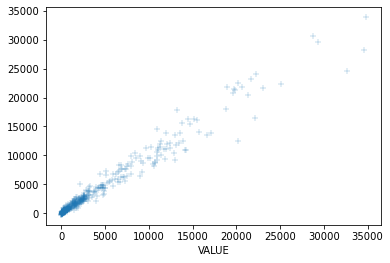

In [ ]:
sns.scatterplot(Y_test, Y_pred, marker="+", alpha=0.5)